# Modelo de Regresión Logística

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import VectorAssembler

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

# Términos cuadráticos añadidos manualmente
bd5 = bd5.withColumn('DepDelay2',(bd5.DEP_DELAY**2)
).withColumn('DepD_Distance',(bd5.DEP_DELAY * bd5.DISTANCE)) 

## Descripción Previa de la Base de Datos

Resumen Numérico

In [4]:
bd5.select('Retraso').describe().show()

+-------+------------------+
|summary|           Retraso|
+-------+------------------+
|  count|             30466|
|   mean|0.2757500164117377|
| stddev|0.4468987584631848|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [5]:
pdf5 = bd5.sample(False, 0.1, 0).select('Retraso','ARR_DELAY','DEP_DELAY',
                                        'DAY_OF_WEEK','CRS_DEP_TIME').toPandas()
pdf5.corr()

,Retraso,ARR_DELAY,DEP_DELAY,DAY_OF_WEEK,CRS_DEP_TIME
Retraso,1.000000,0.507981,0.437363,0.034566,0.124188
ARR_DELAY,0.507981,1.000000,0.973316,0.045201,0.100995
DEP_DELAY,0.437363,0.973316,1.000000,0.040341,0.096217
DAY_OF_WEEK,0.034566,0.045201,0.040341,1.000000,-0.012944
CRS_DEP_TIME,0.124188,0.100995,0.096217,-0.012944,1.000000


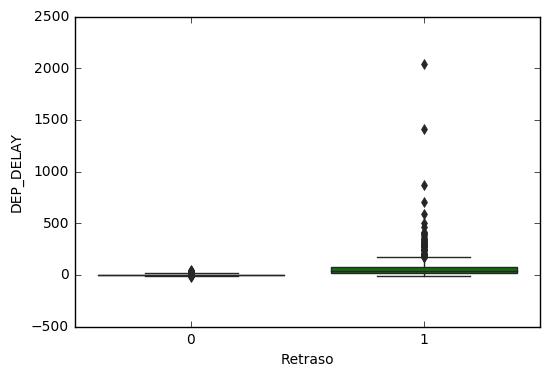

In [6]:
import seaborn as sns
%matplotlib inline

sns.boxplot(x='Retraso',y='DEP_DELAY',data=pdf5)

Configuración de la Base de Datos

In [7]:
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')

bd6 = a1.transform(bd5).select(col("Retraso").cast('double').alias("label"),'features')

In [8]:
bd6.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[-8.0,236.0,4.0,1...|
|  0.0|[6.0,236.0,4.0,12...|
|  0.0|[-5.0,236.0,4.0,1...|
|  0.0|[-6.0,236.0,4.0,8...|
|  0.0|[-5.0,651.0,4.0,2...|
|  0.0|[-5.0,370.0,4.0,1...|
|  0.0|[-8.0,868.0,4.0,1...|
|  0.0|[-6.0,1464.0,4.0,...|
|  0.0|[-3.0,1464.0,4.0,...|
|  0.0|[-6.0,1055.0,4.0,...|
|  0.0|[-11.0,255.0,4.0,...|
|  0.0|(9,[1,2,3],[1440....|
|  0.0|[1.0,641.0,4.0,22...|
|  0.0|[2.0,1440.0,4.0,1...|
|  0.0|[-9.0,1055.0,4.0,...|
|  0.0|[5.0,1055.0,4.0,1...|
|  1.0|[7.0,370.0,4.0,20...|
|  0.0|[-4.0,1055.0,4.0,...|
|  0.0|[-2.0,1055.0,4.0,...|
|  0.0|[-7.0,1464.0,4.0,...|
+-----+--------------------+
only showing top 20 rows



## Ajuste del modelo

In [9]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     threshold=0.5)
                        
model = lgr.fit(bd6)

In [10]:
print(model.intercept,model.coefficients)

-1.6228762950365914 [0.0174818630425,-0.000153907645432,0.00622037724017,0.000243814478493,-0.18527035429,0.0280656797874,0.0553254124157,1.4042617353e-06,9.64852764749e-06]


Los valores predichos se obtienen de:

$p_i = \frac{e^{X_i\beta}}{1+e^{X_i\beta}}$

Siendo $X_i\beta  = \beta_0 + \beta_1 X_{1i} + ... \beta_p X_{pi}$ los valores de raw_prediction.

Los valores de raw_prediction se obtienen a partir de los coeficientes del modelo y las correspondientes variables explicativas

In [11]:
pred = model.transform(bd6)
pred.select('rawPrediction','probability').show(20)


/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+--------------------+--------------------+
|       rawPrediction|         probability|
+--------------------+--------------------+
|[1.38588018074077...|[0.79993372290508...|
|[1.15805757782493...|[0.76097958746655...|
|[1.45534475592752...|[0.81081963453715...|
|[1.52482637822825...|[0.82124809014486...|
|[1.48413341690803...|[0.81519609728737...|
|[1.36274699976021...|[0.79620579443903...|
|[1.46071846651767...|[0.81164253777179...|
|[1.77760088417091...|[0.85540037083745...|
|[1.61064779104856...|[0.83350130426781...|
|[1.51864582301092...|[0.82033898458456...|
|[1.45536111639015...|[0.81082214407465...|
|[1.34393974795933...|[0.79313708498665...|
|[1.31990959905058...|[0.78916666576687...|
|[1.48498453446148...|[0.81532428495909...|
|[1.64910963367082...|[0.83877067855847...|
|[1.21560868546533...|[0.77128983651268...|
|[1.00647032485384...|[0.73232881823788...|
|[1.88315119722244...|[0.86797266035592...|
|[1.57818153756871...|[0.82894682515774...|
|[2.21757755315872...|[0.9018169

Los valores de *probability* son transformados a *prediction* empleando un punto de corte. 

Por defecto: 0.5

In [12]:
pred.select('label','prediction','probability').show(20)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.79993372290508...|
|  0.0|       0.0|[0.76097958746655...|
|  0.0|       0.0|[0.81081963453715...|
|  0.0|       0.0|[0.82124809014486...|
|  0.0|       0.0|[0.81519609728737...|
|  0.0|       0.0|[0.79620579443903...|
|  0.0|       0.0|[0.81164253777179...|
|  0.0|       0.0|[0.85540037083745...|
|  0.0|       0.0|[0.83350130426781...|
|  0.0|       0.0|[0.82033898458456...|
|  0.0|       0.0|[0.81082214407465...|
|  0.0|       0.0|[0.79313708498665...|
|  0.0|       0.0|[0.78916666576687...|
|  0.0|       0.0|[0.81532428495909...|
|  0.0|       0.0|[0.83877067855847...|
|  0.0|       0.0|[0.77128983651268...|
|  1.0|       0.0|[0.73232881823788...|
|  0.0|       0.0|[0.86797266035592...|
|  0.0|       0.0|[0.82894682515774...|
|  0.0|       0.0|[0.90181691326734...|
+-----+----------+--------------------+
only showing top 20 rows



In [13]:
pred.describe().show()

+-------+------------------+-------------------+
|summary|             label|         prediction|
+-------+------------------+-------------------+
|  count|             30466|              30466|
|   mean|0.2757500164117377|0.10802205737543491|
| stddev|0.4468987584631848|0.31041336190561725|
|    min|               0.0|                0.0|
|    max|               1.0|                1.0|
+-------+------------------+-------------------+



### Ajuste

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

evaluator=BCE(rawPredictionCol='rawPrediction',labelCol='label',
              metricName = "areaUnderROC")
#areaUnderPR
evaluator.evaluate(pred)

0.9053308831809515

## Regularización y Selección de Variables

regParam=0, sin penalización (OLS).

elasticNetParam = 0, penalización L2 (Ridge). 

elasticNetParam = 1, penalización L1 (Lasso).

Ridge Regression

In [15]:
lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     regParam=0.5,
     elasticNetParam=0.0)
                        
model = lgr.fit(bd6)
pred = model.transform(bd6)
print(model.intercept,model.coefficients)

-1.3010322347928636 [0.00626416445529,-4.69845926539e-05,0.00776377758017,0.000137146605245,-0.108290451465,-0.00892144636168,0.0343034531299,9.52349580712e-07,3.75833657102e-06]


/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


Lasso Regression

In [16]:
lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     regParam=0.02,
     elasticNetParam=1.0)
                        
model = lgr.fit(bd6)
pred = model.transform(bd6)
print(model.intercept,model.coefficients)

-1.6402992418896536 (9,[0,1,2,8],[0.070204446606,-0.000311812101591,-0.014813395958,7.53966187495e-06])


/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")
